In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
from scipy.stats import norm

In [2]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *
from batching import *
from Adaptive_sampling import *
from Probability_algorithm import *


set_seed()

In [3]:
def analytical_excess_porepressure(time, z, k, mv, H, terms=1000):
    """
    Craig's Soil Mechanics, Seventh edition, Page 248
    Exact analytical solution for Terzaghi's 1D consolidation problem (single drainage).
    
    : time:         Time                                     (years)
    : z:            Depth                                    (m)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : k:            Coefficient of permeability              (m/years)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : terms:        Number of terms in the Fourier series
    : returns:      Excess pore water pressure u(z, t)       (kPa)
    """
    yw = 9.81         # unit weight of water (kN/m³)
    cv = k / (mv*yw)  # coefficient of consolidation (m²/day) 
    Tv= cv*time/H**2  # dimensionless time
    ue = 0.0
    for i in range (terms):
        M = np.pi/2* (2*i+1)
        ue+= 2/M * np.sin(M*z/H) * np.exp(-M**2*Tv)
    return ue

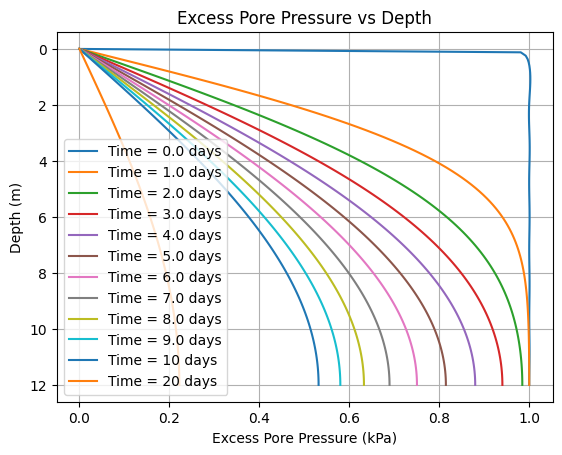

In [4]:
H=12
k= 2e-2
mv=4e-4
T=10
delta_sigma = 1
cv = k / (mv*9.81)  # Coefficient of consolidation (m²/day)

z = np.linspace(0, H, 100)  # Depth in meters for plotting
times = [10*t for t in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]]  # Time in days
for t in times:
    u_vals = analytical_excess_porepressure(t, z, k, mv, H)*delta_sigma
    plt.plot(u_vals, z, label=f'Time = {t} days')

# Plotting the analytical solution

plt.xlabel('Excess Pore Pressure (kPa)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Excess Pore Pressure vs Depth')
plt.legend()
plt.grid()
plt.show()

In [5]:
def exact_degree_of_consolidation(time, k, mv, H, terms=100):
    """
    Craig's Soil Mechanics, Seventh edition, Page 250
    Exact analytical solution for Terzaghi's 1D consolidation problem (double drainage).
    
    : time:         Time                                     (years)
    : z:            Depth                                    (m)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : k:            Coefficient of permeability              (m/year)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : terms:        Number of terms in the Fourier series
    : returns:      Excess pore water pressure u(z, t)       (kPa)
    """
    cv = k / (9.81*mv)  # coefficient of consolidation (m²/year)
    Tv= cv*time/H**2 # dimensionless time
    U = 0.0
    for i in range(terms):
        M = np.pi/2* (2*i+1)
        U += 2/M**2 * np.exp(-M**2*Tv)
    return (1-U)

In [6]:
def exact_consolidation(U_t, mv, H):
    """    
    : U_t:          Degree of consolidation                   (-)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : returns:      
    """
    return  U_t * mv * H

In [7]:
from scipy.integrate import simpson 
def total_settlement(time, k, mv, H, terms=100, num_points=1000):
    """
    Compute the total settlement at a given time by integrating effective stress
    calculated from excess pore pressure over the depth.

    : time:         Time (# of years)
    : delta_sigma:  Applied vertical stress increment (kPa)
    : k:            Coefficient of permeability (m/year)
    : mv:           Coefficient of volume compressibility (m²/kN)
    : H:            Thickness of the soil layer (m)
    : terms:        Number of Fourier terms
    : num_points:   Number of depth points to integrate over
    : returns:      Settlement s(t) in meters
    """
    z_vals = np.linspace(0, H, num_points)
    u_vals = analytical_excess_porepressure(time, z_vals, k, mv, H, terms)
    
    # Effective stress = delta_sigma - u
    effective_stress = 1 - u_vals

    # Integrate effective stress over depth to get strain, then multiply by mv
    settlement = mv * simpson(effective_stress, x=z_vals)  # or np.trapz

    return settlement

In [8]:
exact_degree = exact_degree_of_consolidation(10, k, mv, H)
exact_consolidation_height = exact_consolidation(exact_degree, mv, H)*100 #kPa

print(f"Exact degree of consolidation: {exact_degree:.5f} (-)")
print(f"Exact consolidation: {exact_consolidation_height:.18f} (m)")

total_settlement_value = total_settlement(10, k, mv, H) * 100 #kPa
print(total_settlement_value)

Exact degree of consolidation: 0.66150 (-)
Exact consolidation: 0.317522294860152932 (m)
0.31752229486014744


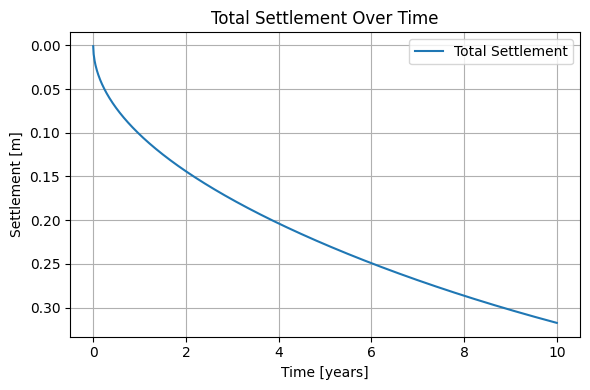

Total settlement: 0.31752 m


In [9]:
# Generate settlement values over time using exact_degree_of_consolidation and exact_consolidation
time_range = np.linspace(0, 10, 1000)  # Time in years (0 to 10 years)
degree_of_consolidation_values = [exact_degree_of_consolidation(t, k, mv, H) for t in time_range]
settlement_values = [exact_consolidation(U_t, mv, H)*100 for U_t in degree_of_consolidation_values]

# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(time_range, settlement_values, label="Total Settlement")

# Add labels, title, and grid
plt.xlabel("Time [years]")
plt.ylabel("Settlement [m]")
plt.title("Total Settlement Over Time")
plt.grid(True)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.tight_layout()
plt.show()
print("Total settlement:", f"{settlement_values[-1]:.5f}", "m")